In [2]:
import torch
import numpy as np
import glob
import os
import random
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

from torch import nn
from torchvision import transforms

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset_dir = 'yeast_processed_log_norm_area_50'
model_dir = 'unet2D_aug_norm'

used some code from: https://github.com/seyma-tas/Brain-Tumor-Segmentation-Project/blob/master/2AdamW_DICE_BrainTumorGenesis.ipynb
also used: https://github.com/MrGiovanni/ModelsGenesis

# Accuracy and Loss Metrics

In [3]:
def dice_metric(inputs, target):
    num = target.shape[0]
    chans = target.shape[1]
    inputs = inputs.reshape(num, chans, -1)
    target = target.reshape(num, chans, -1)
    
    
    intersection = 2.0 * (target * inputs).sum(2)
    union = target.sum(2) + inputs.sum(2)
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return (intersection / union).mean()

def jaccard_index(inputs, target):
    num = target.shape[0]
    chans = target.shape[1]
    inputs = inputs.reshape(num, chans, -1)
    target = target.reshape(num, chans, -1)
    
    intersection = (target * inputs).sum(2)
    union = target.sum(2) + inputs.sum(2) - intersection
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return (intersection / union).mean()

# def dice_loss(inputs, target):
#     num = target.size(0)
#     chans = target.size(1)
#     inputs = inputs.reshape(num*chans, -1)
#     target = target.reshape(num*chans, -1)
#     smooth = 1.0
#     intersection = (inputs * target)
#     dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
#     dice = 1 - dice.sum() / (num*chans)
#     return dice

# def bce_dice_loss(inputs, target):
#     dicescore = dice_loss(inputs, target)
#     bcescore = nn.BCELoss()
#     bceloss = bcescore(inputs, target)

#     return bceloss + dicescore

def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# Model
From https://github.com/MrGiovanni/ModelsGenesis

In [4]:


class ContBatchNorm2d(nn.modules.batchnorm._BatchNorm):
    def _check_input_dim(self, input):

        if input.dim() != 4:
            raise ValueError('expected 4D input (got {}D input)'.format(input.dim()))
        #super(ContBatchNorm3d, self)._check_input_dim(input)

    def forward(self, input):
        self._check_input_dim(input)
        return F.batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            True, self.momentum, self.eps)


class LUConv(nn.Module):
    def __init__(self, in_chan, out_chan, act):
        super(LUConv, self).__init__()
        self.conv1 = nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1)
        self.bn1 = ContBatchNorm2d(out_chan)

        if act == 'relu':
            self.activation = nn.ReLU(out_chan)
        elif act == 'prelu':
            self.activation = nn.PReLU(out_chan)
        elif act == 'elu':
            self.activation = nn.ELU(inplace=True)
        else:
            raise

    def forward(self, x):
        out = self.activation(self.bn1(self.conv1(x)))
        return out


def _make_nConv(in_channel, depth, act, double_chnnel=False):
    if double_chnnel:
        layer1 = LUConv(in_channel, 32 * (2 ** (depth+1)),act)
        layer2 = LUConv(32 * (2 ** (depth+1)), 32 * (2 ** (depth+1)),act)
    else:
        layer1 = LUConv(in_channel, 32*(2**depth),act)
        layer2 = LUConv(32*(2**depth), 32*(2**depth)*2,act)

    return nn.Sequential(layer1,layer2)

class DownTransition(nn.Module):
    def __init__(self, in_channel,depth, act):
        super(DownTransition, self).__init__()
        self.ops = _make_nConv(in_channel, depth,act)
        self.maxpool = nn.MaxPool2d(2)
        self.current_depth = depth

    def forward(self, x):
        if self.current_depth == 3:
            out = self.ops(x)
            out_before_pool = out
        else:
            out_before_pool = self.ops(x)
            out = self.maxpool(out_before_pool)
        return out, out_before_pool

class UpTransition(nn.Module):
    def __init__(self, inChans, outChans, depth,act):
        super(UpTransition, self).__init__()
        self.depth = depth
        self.up_conv = nn.ConvTranspose2d(inChans, outChans, kernel_size=2, stride=2)
        self.ops = _make_nConv(inChans+ outChans//2,depth, act, double_chnnel=True)

    def forward(self, x, skip_x):
        out_up_conv = self.up_conv(x)
        concat = torch.cat((out_up_conv,skip_x),1)
        out = self.ops(concat)
        return out


class OutputTransition(nn.Module):
    def __init__(self, inChans, n_labels):

        super(OutputTransition, self).__init__()
        self.final_conv = nn.Conv2d(inChans, n_labels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.sigmoid(self.final_conv(x))
        return out

class UNet2D(nn.Module):
    # the number of convolutions in each layer corresponds
    # to what is in the actual prototxt, not the intent
    def __init__(self, n_class=1, n_channels=1, act='relu'):
        super(UNet2D, self).__init__()

        self.down_tr64 = DownTransition(n_channels,0,act)
        self.down_tr128 = DownTransition(64,1,act)
        self.down_tr256 = DownTransition(128,2,act)
        self.down_tr512 = DownTransition(256,3,act)

        self.up_tr256 = UpTransition(512, 512,2,act)
        self.up_tr128 = UpTransition(256,256, 1,act)
        self.up_tr64 = UpTransition(128,128,0,act)
        self.out_tr = OutputTransition(64, n_class)

    def forward(self, x):
        self.out64, self.skip_out64 = self.down_tr64(x)
        self.out128,self.skip_out128 = self.down_tr128(self.out64)
        self.out256,self.skip_out256 = self.down_tr256(self.out128)
        self.out512,self.skip_out512 = self.down_tr512(self.out256)

        self.out_up_256 = self.up_tr256(self.out512,self.skip_out256)
        self.out_up_128 = self.up_tr128(self.out_up_256, self.skip_out128)
        self.out_up_64 = self.up_tr64(self.out_up_128, self.skip_out64)
        self.out = self.out_tr(self.out_up_64)

        return self.out



# Load and define dataset


In [5]:
class DatasetSegmentation(torch.utils.data.Dataset):
    
    def __init__(self, folder_path, transform = None, normalize_transform = None, interp_size = 512):
        super(DatasetSegmentation, self).__init__()
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.compose([
                transforms.Resize((interp_size, interp_size), interpolation=0)
            ])
            
        if normalize_transform:
            self.normalize_transform = normalize_transform
        else:
            self.normalize_transform = None
        
        self.interp_size = interp_size
        self.img_files = glob.glob(os.path.join(folder_path,'features','*.npy'))
        self.mask_files = []
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(folder_path, 'masks', os.path.basename(img_path)) )

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]

        data = np.load(img_path)
        label = np.load(mask_path)
        
        # print(data.dtype)
        
        data = torch.from_numpy(data).float()
        label = torch.from_numpy(label).float()
        
        samp = torch.cat((data, label))
        
        samp = self.transform(samp)
        data = samp[:-1]
        label = samp[-1].unsqueeze(0)
        
        if self.normalize_transform:
            data = self.normalize_transform(data)
            

#         data = F.interpolate(data.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
#         label = F.interpolate(label.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
        return data, label

    def __len__(self):
        return len(self.img_files)

In [6]:
import json

with open(os.path.join('data', dataset_dir, 'stds.json'), 'r') as f:
    stds = json.load(f)
    
stds

[[0.025770971551537514,
  0.2516340911388397,
  0.023633284494280815,
  0.11163000762462616],
 [0.02316989190876484,
  0.22105874121189117,
  0.06039806827902794,
  0.1474960595369339]]

In [7]:
normalize_transform = transforms.Normalize(
                                    stds[0],
                                    stds[1])


class RandomTranspose(object):
    """Randomly transpose sample
    """

    def __call__(self, sample):
        transpose = random.random() < 0.5
        if transpose:
            # sample is CxHxW
            return torch.transpose(sample, -1, -2)
        else:
            return sample


transform_dict = {'train': transforms.Compose([
                transforms.Resize((512,512), interpolation=0),
                RandomTranspose(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
            ]),
             'val': transforms.Compose([
                transforms.Resize((512,512), interpolation=0),
            ])}

ds_train = DatasetSegmentation(os.path.join('data', dataset_dir, 'train'), transform=transform_dict['train'], normalize_transform=normalize_transform)
ds_test = DatasetSegmentation(os.path.join('data', dataset_dir, 'test'), transform=transform_dict['val'], normalize_transform=normalize_transform)
ds_val = DatasetSegmentation(os.path.join('data', dataset_dir, 'val'), transform=transform_dict['val'], normalize_transform=normalize_transform)

In [8]:
ds_train.__len__(), ds_test.__len__()

(892, 111)

In [9]:
sample = ds_train.__getitem__(12)

In [10]:
sample[1].shape

torch.Size([1, 512, 512])

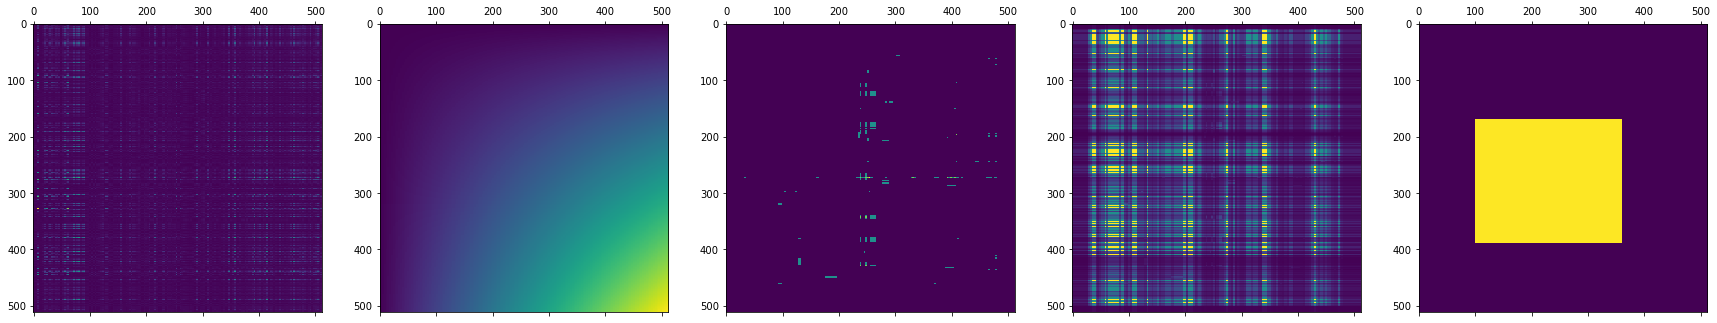

In [11]:
fig, axs = plt.subplots(1,5, figsize=(30,30))
axs[0].matshow(sample[0][0].view(512,512))
axs[1].matshow(sample[0][1].view(512,512))
axs[2].matshow(sample[0][2].view(512,512))
axs[3].matshow(sample[0][3].view(512,512))
axs[4].matshow(sample[1][0].view(512,512))
plt.show()

In [12]:
train_dataloader = torch.utils.data.DataLoader(ds_train, batch_size=2, num_workers=0, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(ds_test, batch_size=2, num_workers=0, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(ds_val, batch_size=2, num_workers=0, shuffle=False)

# Setup Model 

In [13]:
model = UNet2D(n_class=sample[1].shape[0], n_channels=sample[0].shape[0])

## Parameters
Setup loss function:

In [14]:
criterion = bce_dice_loss

Setup optimizer

In [15]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=0.1)

In [16]:
from torch.optim import lr_scheduler 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Prepare Training

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Train

Start train...


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Batch:   0%|          | 0/446 [00:00<?, ?it/s]

epoch 0 train loss 1.2944797189246378 val loss 1.2716069029910224
epoch 1 train loss 1.2795701302220468 val loss 1.272288286260196
epoch 2 train loss 1.272593493953414 val loss 1.2968847560031074
epoch 3 train loss 1.279495256096793 val loss 1.3107522023575646
epoch 4 train loss 1.279134302930447 val loss 1.27108291217259
epoch 5 train loss 1.2718457908373777 val loss 1.265299066901207
epoch 6 train loss 1.2749430620082292 val loss 1.2682769830737795
epoch 7 train loss 1.2680615972510367 val loss 1.2609772107430868
epoch 8 train loss 1.26395093512642 val loss 1.2606643353189741
epoch 9 train loss 1.259012765948548 val loss 1.2414262805666243
epoch 10 train loss 1.244700523235338 val loss 1.2368385600192207
epoch 11 train loss 1.2408197289625091 val loss 1.220846904175622
epoch 12 train loss 1.2359509498816434 val loss 1.235784915941102
epoch 13 train loss 1.2010641874486556 val loss 1.1633122222764152
epoch 14 train loss 1.1716283900588083 val loss 1.1355990948421615
epoch 15 train los

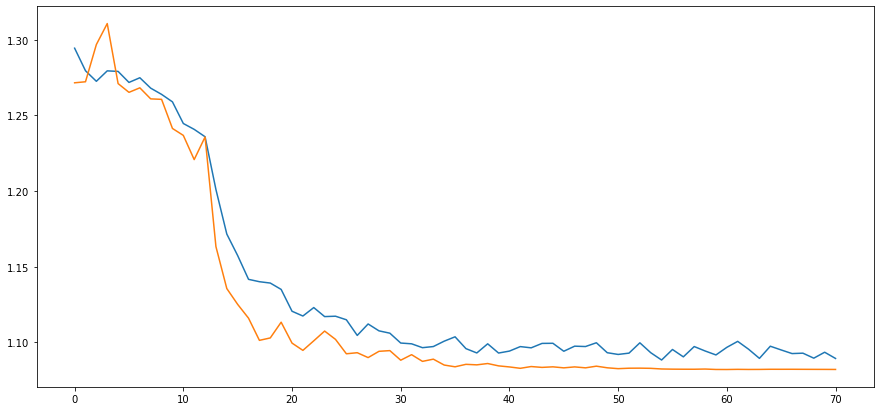

In [17]:
from tqdm.autonotebook import tqdm

if not os.path.isdir(f'./models/{model_dir}/'):
    os.mkdir(f'./models/{model_dir}/')
if not os.path.isdir(f'./models/{model_dir}/{dataset_dir}/'):
    os.mkdir(f'./models/{model_dir}/{dataset_dir}/')

epochs = 1000
min_epochs = 20
early_stop_crit = 10

model.to(device)

# Initialize lists to store loss values
loss_history = []
loss_history_val = []

best_loss_val = float('inf')


early_stop_count = 0
# Train
print("Start train...")
outer = tqdm(total=epochs, desc='Epochs', position=0)
inner = tqdm(total=len(train_dataloader), desc=f'Batch', position=1)
for epoch in range(epochs):
    # check to see if validation loss has plateau'd
    if early_stop_count >= early_stop_crit and epochs > min_epochs:
        print(f'Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch')
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, f'./models/{model_dir}/{dataset_dir}/checkpt_earlystop_{epoch}.pth')
        break
    
    early_stop_count += 1
    
   #Train mode
    model.train()
    loss_running = []
    
    inner.refresh()  #force print final state
    inner.reset()  #reuse bar    
    for _, (x,y) in enumerate(train_dataloader):
        x, y = x.float().to(device), y.float().to(device)
        
        pred = model(x)
        loss = criterion(pred, y)
        loss_running.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        inner.update(1)
        
    loss_history.append(np.mean(loss_running))
    # Evaluate mode
    model.eval()
    with torch.no_grad():
        loss_val_running = []
        for _, (x_val, y_val) in enumerate(val_dataloader):
            x_val, y_val = x_val.to(device), y_val.to(device)
            pred_val = model.forward(x_val) #pred_val = model(x_val)
            loss_val= criterion(pred_val, y_val)
            loss_val_running.append(loss_val.item())
    
    
    curr_loss_val = np.mean(loss_val_running)
    loss_history_val.append(curr_loss_val)
    
    # Change the learning rate
    scheduler.step()
    
    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, f'./models/{model_dir}/{dataset_dir}/best_model.pth')
        early_stop_count = 0
    
    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= epochs-1:
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, f'./models/{model_dir}/{dataset_dir}/checkpt{epoch}.pth')
        
    # Print the results    
    outer.update(1)
    print("epoch", epoch, "train loss", loss_history[-1], "val loss", loss_history_val[-1])


# Print loss history
plt.figure(figsize=(15, 7))
plt.plot(loss_history)
plt.plot(loss_history_val)

# Evaluate

In [18]:
checkpoint = torch.load(f'./models/{model_dir}/{dataset_dir}/best_model.pth',
                        map_location=torch.device('cpu'))

model = checkpoint['model']
model.cuda()
model.eval()
torch.set_grad_enabled(False)

In [19]:
# def mask_to_box(mask, tail=0.0):
#     cumsum_b = np.cumsum(mask.sum(0))
#     cumsum_a = np.cumsum(mask.sum(1))
    
#     # right at beginning of range makes sure it searches for the first index not of the value
#     # left at end of range makes sure it searches for the last index of the value
#     range_a = (np.searchsorted(cumsum_a, np.quantile(cumsum_a, tail), side='right'), np.searchsorted(cumsum_a, np.quantile(cumsum_a, 1.0-tail), side='left'))
#     range_b = (np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail), side='right'), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1.0-tail), side='left'))
#     return range_a, range_b
from scipy import ndimage

def mask_to_box_many(a, max_label=0):
    labels, n = ndimage.measurements.label(a, np.ones((3, 3)))
              
    if max_label < n:
                    
        # find largest contiguous areas
        # print(n)
        uniques, counts = np.unique(labels, return_counts=True)
        # print(max_label)
        # print(counts)
        ind = np.argpartition(counts, -(max_label+1))[-(max_label+1):] # find indices of top max_label counts; +1 because 0 will be one of them
        # print(ind)
        
        top_uniques = uniques[ind]
        top_counts = counts[ind]
        
        # remove 0
        if 0 in top_uniques:
            rm_i = np.where(top_uniques == 0)
        else:
            # we have 1 too many, remove smallest value
            rm_i = np.argmin(top_counts)
            
        top_counts = np.delete(top_counts, rm_i)
        top_uniques = np.delete(top_uniques, rm_i)
        
#         print(top_uniques)
#         print(top_counts)
#         print(type(top_uniques))
#         print(np.vectorize(lambda label: label in top_uniques)(labels))
        
        # zero out anything that's not in top max_label uniques:
        labels = np.where(np.vectorize(lambda label: label in top_uniques)(labels), labels, 0)
        
#         print(np.unique(labels))
    
        
        
    
    objs = ndimage.find_objects(labels)

    # filter out nones
    return list(filter(None, objs)) 

def mask_to_box(a, max_label=1):
    objs = ndimage.find_objects(a, max_label=max_label)

    # Get the height and width
    return objs

# def mask_to_box_rounded(a):
#     objs = ndimage.find_objects(a, max_label=1)

#     # Get the height and width
#     return objs

In [20]:
# import matplotlib

# cmap = mpl.cm.ScalarMappable
# norm = mpl.colors.Normalize(vmin=0, vmax=1)

# cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
#                                 norm=norm)
from matplotlib.patches import Rectangle

def plot_mask(mask_cpu, axx, round=False, title=None, bbs=[], bbs2=[]):
    # takes 64*64*64 array
    mask_cpu = mask_cpu.cpu().detach().numpy()
    if round:
        mask_cpu = np.round(mask_cpu)
    ax = axx.matshow(mask_cpu)
    if title:
        axx.set_title(title)
    axx.set_ylabel('Sequence A')
    axx.set_xlabel('Sequence B')
    # ax.set_clim(0, 1)
    axx.set_xticks([])
    axx.set_yticks([])
    
    for bb in bbs:
        if bb:
            rect = Rectangle((bb[1].start,bb[0].start),bb[1].stop-bb[1].start,bb[0].stop-bb[0].start,linewidth=1,edgecolor='r',facecolor='none')

            # Add the patch to the Axes
            axx.add_patch(rect)
            
    for bb in bbs2:
        if bb:
            rect = Rectangle((bb[1].start,bb[0].start),bb[1].stop-bb[1].start,bb[0].stop-bb[0].start,linewidth=1,edgecolor='w',facecolor='none')

            # Add the patch to the Axes
            axx.add_patch(rect)
    
    plt.colorbar(ax, ax=axx)

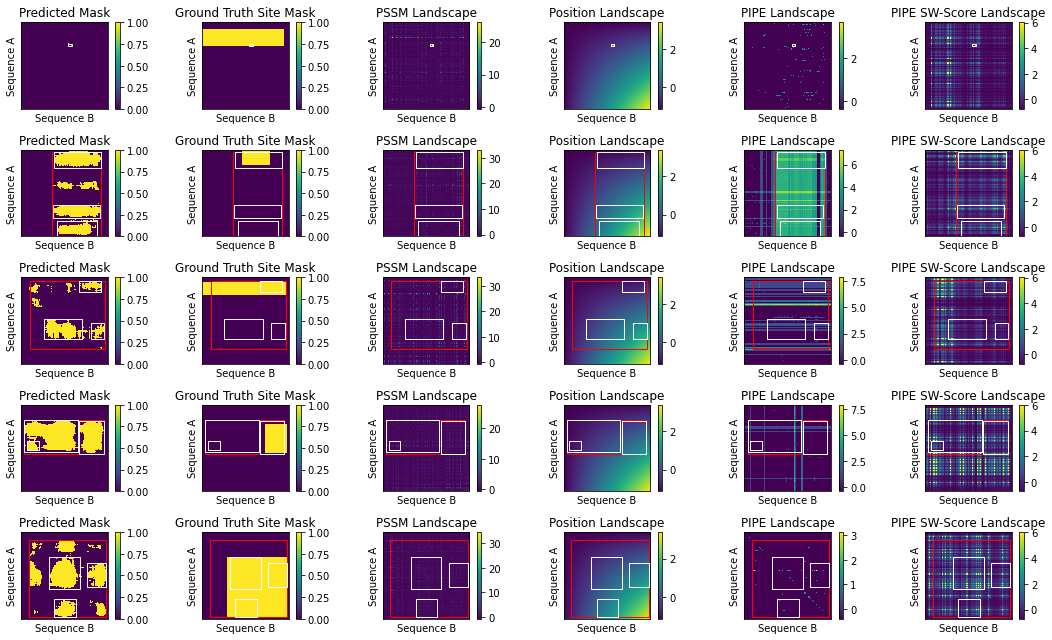

In [21]:
dataloader = test_dataloader
ncol = 6
nrows=5
random.seed(839)
rand_ndx = random.sample(range(0, len(dataloader)), nrows)
fig, ax = plt.subplots(nrows=nrows,  ncols=ncol, figsize=(15, 9))
i = 0
for n, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    if n in rand_ndx:
        pred = model.forward(x)

        # calculate bounding boxes
        bbs_many = mask_to_box_many(pred[0,0,:,:].cpu().numpy().round().astype(int), max_label=3)
        bbs = mask_to_box(pred[0,0,:,:].cpu().numpy().round().astype(int), max_label=1)
#         bb25 = mask_to_box(pred[0,0,:,:], tail=0.25)
#         bb33 = mask_to_box(pred[0,0,:,:], tail=0.4)
        
        plot_mask(pred[0,0,:,:], ax[i][0], round=True, title="Predicted Mask", bbs=bbs, bbs2 = bbs_many)
        plot_mask(y[0,0,:,:], ax[i][1], title='Ground Truth Site Mask', bbs=bbs, bbs2 = bbs_many)
        plot_mask(x[0,0,:,:], ax[i][2], title='PSSM Landscape', bbs=bbs, bbs2 = bbs_many)
        plot_mask(x[0,1,:,:], ax[i][3], title='Position Landscape', bbs=bbs, bbs2 = bbs_many)
        plot_mask(x[0,2,:,:], ax[i][4], title='PIPE Landscape', bbs=bbs, bbs2 = bbs_many)
        plot_mask(x[0,3,:,:], ax[i][5], title='PIPE SW-Score Landscape', bbs=bbs, bbs2 = bbs_many)
        i+=1
        
plt.tight_layout()

# Function to compute the dice accuracy

In [22]:
def compute_acc(dataloader, model):
    acc = []
    loss = []
    jacc = []
    #model.eval()
    #with torch.no_grad():
    for _, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss.append(bce_dice_loss(pred, y).item())
        # loss.append(BCELoss)    
        acc.append(dice_metric(pred.data.cpu().numpy().round(), y.data.cpu().numpy()))
        jacc.append(jaccard_index(pred.data.cpu().numpy().round(), y.data.cpu().numpy()))
       
    print(f'Loss: {np.mean(loss)}, Accuracy (dice): {np.mean(acc)}, Jaccard Index: {np.mean(jacc)}')

# Compute dice accuracy for train, validation and test data

In [23]:
compute_acc(test_dataloader, model)

Loss: 1.0867904552391596, Accuracy (dice): 0.3511003851890564, Jaccard Index: 0.25280457735061646


In [24]:
compute_acc(train_dataloader, model)

Loss: 1.091587348770133, Accuracy (dice): 0.36264392733573914, Jaccard Index: 0.2581944763660431


In [25]:
compute_acc(val_dataloader, model)

Loss: 1.0820880425827843, Accuracy (dice): 0.36273956298828125, Jaccard Index: 0.2583264708518982


## Test totally random

In [26]:
model = UNet2D(n_class=sample[1].shape[0], n_channels=sample[0].shape[0])
model.cuda()
model.eval()
compute_acc(test_dataloader, model)

Loss: 1.5040619777781623, Accuracy (dice): 0.238178089261055, Jaccard Index: 0.14547231793403625


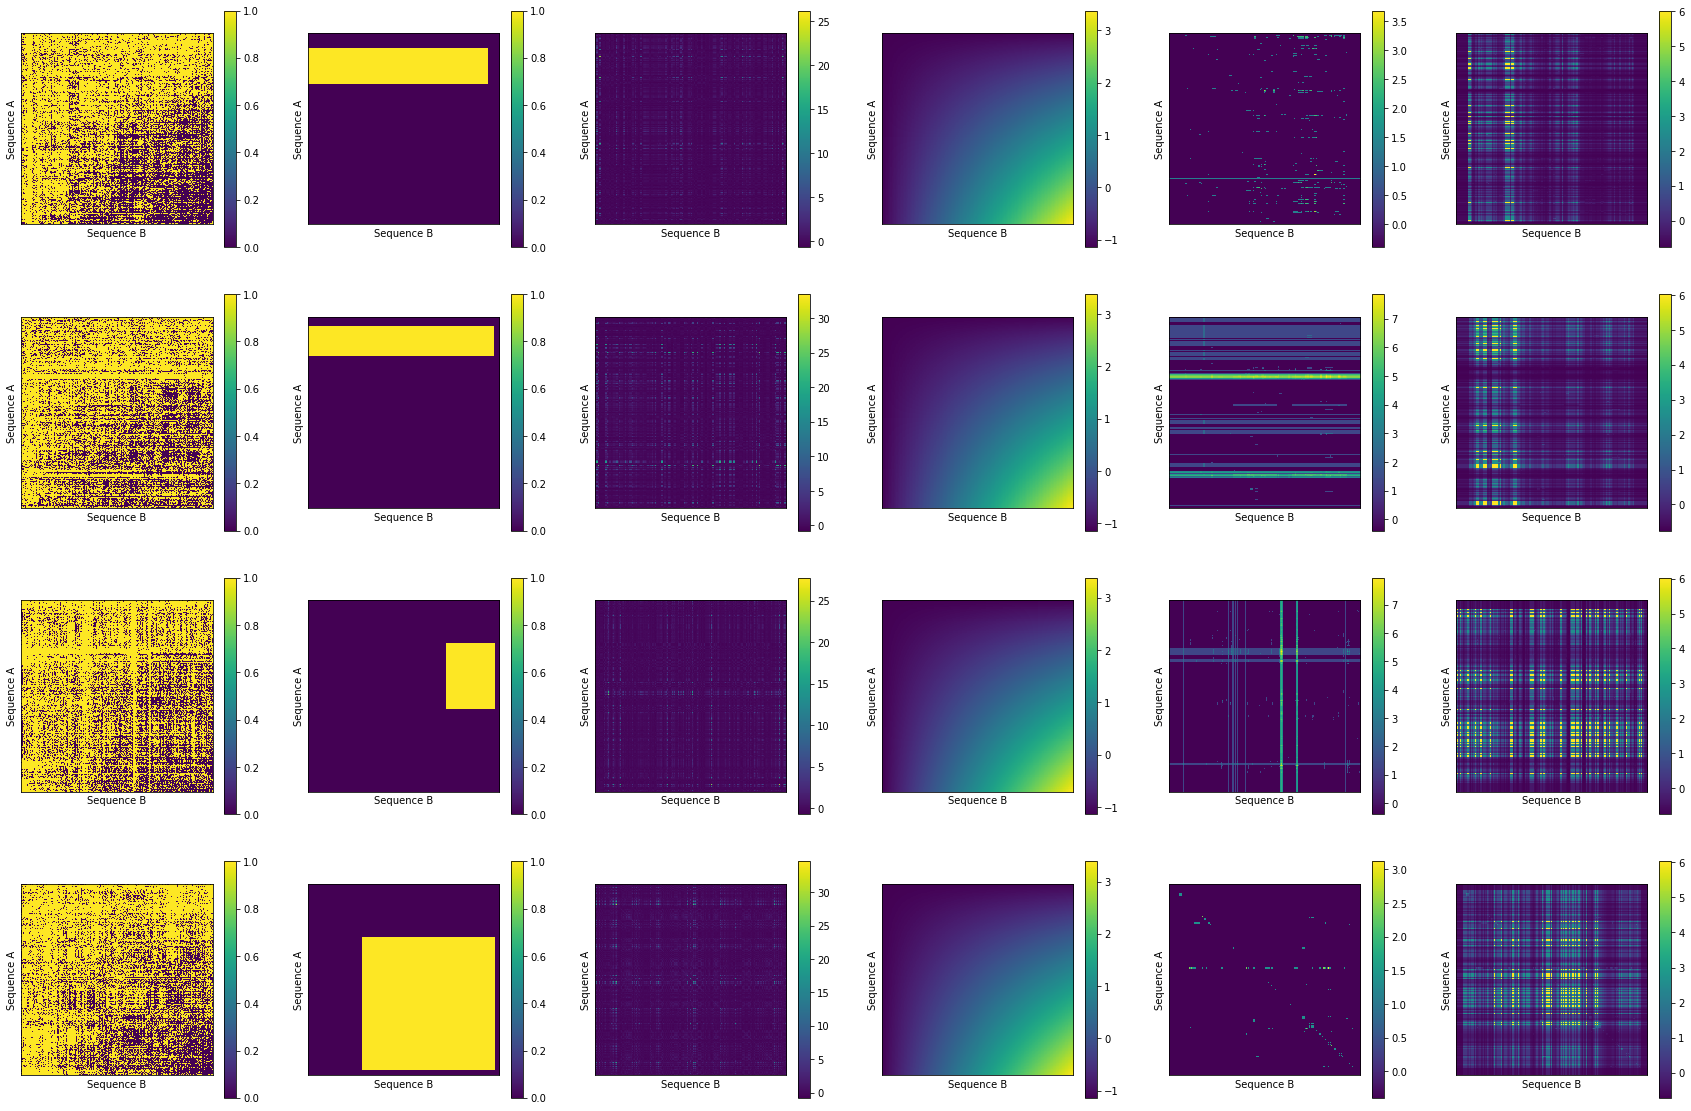

In [27]:
dataloader = test_dataloader
ncol = 6
nrows=4
random.seed(839)
rand_ndx = random.sample(range(0, len(dataloader)), nrows)
fig, ax = plt.subplots(nrows=nrows,  ncols=ncol, figsize=(30, 20))
i = 0
for n, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    if n in rand_ndx:
        pred = model.forward(x)
        plot_mask(pred[0,0,:,:], ax[i][0], round=True)
        plot_mask(y[0,0,:,:], ax[i][1])
        plot_mask(x[0,0,:,:], ax[i][2])
        plot_mask(x[0,1,:,:], ax[i][3])
        plot_mask(x[0,2,:,:], ax[i][4])
        plot_mask(x[0,3,:,:], ax[i][5])
        i+=1

# Convert to bounding boxes

Create dataset object that can take pair names

In [28]:
class DatasetBB(torch.utils.data.Dataset):
    
    def __init__(self, folder_path, transform = None, normalize_transform = None, interp_size = 512):
        super(DatasetBB, self).__init__()
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.compose([
                transforms.Resize((interp_size, interp_size), interpolation=0)
            ])
        self.normalize_transform = None
        
        self.interp_size = interp_size
        self.img_files = glob.glob(os.path.join(folder_path,'features','*.npy'))
        self.mask_files = []
        self.pair_names = []
        for img_path in self.img_files:
            self.mask_files.append(os.path.join(folder_path,'masks',os.path.basename(img_path)) )
            self.pair_names.append(os.path.splitext(os.path.basename(img_path))[0])

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]

        data = np.load(img_path)
        label = np.load(mask_path)
        
        data = torch.from_numpy(data).float()
        label = torch.from_numpy(label).float()
        
        samp = torch.cat((data, label))
        
        samp = self.transform(samp)
        data = samp[:-1]
        label = samp[-1].unsqueeze(0)
        
        if self.normalize_transform:
            data = self.normalize_transform(data)
            

#         data = F.interpolate(data.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
#         label = F.interpolate(label.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
        return data, label, self.pair_names[index]

    def __len__(self):
        return len(self.img_files)



In [29]:
ds_test = DatasetBB(os.path.join('data', dataset_dir, 'test'), transform=transform_dict['val'], normalize_transform=normalize_transform)
ds_val = DatasetBB(os.path.join('data', dataset_dir, 'val'), transform=transform_dict['val'], normalize_transform=normalize_transform)

In [30]:
ds_test.__getitem__(0)

(tensor([[[2.4737e-02, 2.4737e-02, 2.5345e-02,  ..., 3.2462e-02,
           3.2462e-02, 1.7099e-02],
          [2.4737e-02, 2.4737e-02, 2.5345e-02,  ..., 3.2462e-02,
           3.2462e-02, 1.7099e-02],
          [2.4130e-02, 2.4130e-02, 2.6300e-02,  ..., 3.4546e-02,
           3.4546e-02, 1.7099e-02],
          ...,
          [1.6231e-02, 1.6231e-02, 1.6144e-02,  ..., 1.9096e-02,
           1.9096e-02, 3.3678e-02],
          [1.8054e-02, 1.8054e-02, 1.8835e-02,  ..., 2.8991e-02,
           2.8991e-02, 2.2073e-01],
          [1.5971e-02, 1.5971e-02, 1.5190e-02,  ..., 1.6318e-02,
           1.6318e-02, 2.6126e-02]],
 
         [[6.2924e-06, 6.2924e-06, 1.2585e-05,  ..., 1.9507e-03,
           1.9507e-03, 1.9569e-03],
          [6.2924e-06, 6.2924e-06, 1.2585e-05,  ..., 1.9507e-03,
           1.9507e-03, 1.9569e-03],
          [1.2585e-05, 1.2585e-05, 2.5170e-05,  ..., 3.9013e-03,
           3.9013e-03, 3.9139e-03],
          ...,
          [3.2028e-03, 3.2028e-03, 6.4057e-03,  ..., 9.928

In [31]:
test_dl = torch.utils.data.DataLoader(ds_test, batch_size=1, num_workers=0, shuffle=False)
val_dl = torch.utils.data.DataLoader(ds_val, batch_size=1, num_workers=0, shuffle=False)

In [32]:
# data, mask, pairname = iter(test_dl).next()

In [33]:
# data.shape, mask.shape

In [34]:
# mask.to(device)

In [35]:
# pred = model(data.to(device))

In [36]:
# pred.shape

In [37]:
# torch.randn(2, 4).sum(0)

In [38]:
# cumsum_b = np.cumsum(pred.view(512,512).sum(0).cpu().numpy())
# cumsum_a = np.cumsum(pred.view(512,512).sum(1).cpu().numpy())

In [39]:
# tail=0.25
# np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail)), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1-tail))

In [40]:
# plt.matshow(pred[0,0,:,:].detach().cpu().numpy())
# plt.colorbar()

In [41]:
# plt.matshow(mask[0,0,:,:].detach().cpu().numpy())
# plt.colorbar()

In [42]:
# def mask_to_box(mask, tail=0.0):
#     cumsum_b = np.cumsum(mask[0,0,:,:].max(0).cpu().numpy())
#     cumsum_a = np.cumsum(mask[0,0,:,:].max(1).cpu().numpy())
    
#     # right at beginning of range makes sure it searches for the first index not of the value
#     # left at end of range makes sure it searches for the last index of the value
#     range_a = (np.searchsorted(cumsum_a, np.quantile(cumsum_a, tail), side='right'), np.searchsorted(cumsum_a, np.quantile(cumsum_a, 1-tail), side='left'))
#     range_b = (np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail), side='right'), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1-tail), side='left'))
#     return range_a, range_b

In [43]:
# cumsum_b = np.cumsum(np.round(pred[0,0,:,:].cpu().numpy().max(axis=0)))
# cumsum_a = np.cumsum(np.round(pred[0,0,:,:].cpu().numpy().max(axis=1)))

In [44]:
# plt.plot(cumsum_b)

In [45]:
# plt.plot(cumsum_a)

In [46]:
# tail=0.20
# (np.searchsorted(cumsum_a, np.quantile(cumsum_a, tail), side='right'), np.searchsorted(cumsum_a, np.quantile(cumsum_a, 1-tail), side='left'))

In [47]:
# (np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail), side='right'), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1-tail), side='left'))

In [48]:
# np.quantile(cumsum_a, tail)

In [49]:
# np.quantile(cumsum_b, tail)

In [50]:
# ndimage.find_objects(np.zeros((50,50), dtype=np.int), max_label=1)

In [51]:
# plt.matshow(pred[0,0,:,:].cpu().numpy().round().astype(int))

In [52]:
# mask_to_box(mask[0,0,:,:].cpu().numpy().round().astype(int))

## Get predictions and turn them into bounding boxes

In [53]:
checkpoint = torch.load(f'./models/{model_dir}/{dataset_dir}/best_model.pth',
                        map_location=torch.device('cpu'))

model = checkpoint['model']
model.cuda()
model.eval()
torch.set_grad_enabled(False)

top_n = 3
import pandas as pd


def get_predictions_to_bbs(dataloader, model, top_n):
    
    model.cuda()
    model.eval()
    torch.set_grad_enabled(False)
    
    bb_preds = []
    bb_preds_many = []
    bb_trues = []
    pairnames = []
    
    for _, (data, mask, pairname) in enumerate(dataloader):
        data, mask = data.to(device), mask.to(device)

        pred = model(data)

        pred = pred[0,0,:,:].cpu().numpy().round().astype(int)
        mask = mask[0,0,:,:].cpu().numpy().round().astype(int)
        

        bb_preds.append(mask_to_box(pred))
        bb_preds_many.append(mask_to_box_many(pred, max_label=top_n))
        bb_trues.append(mask_to_box(mask))
        pairnames.append(pairname)
        
#         plt.matshow(pred)
        
#         break
    
    return pd.DataFrame(list(zip(pairnames, bb_preds, bb_preds_many, bb_trues)), columns=['pair', 'pred', 'pred_many', 'true'])
    
test_df = get_predictions_to_bbs(test_dl, model, top_n)
val_df = get_predictions_to_bbs(val_dl, model, top_n)

# bb_preds_test = []
# bb_preds_many_test = []
# bb_trues_test = []
# pairnames_test = []
# for _, (data, mask, pairname) in enumerate(test_dl):
#     data, mask = data.to(device), mask.to(device)
    
#     pred = model(data)
    
#     pred = pred[0,0,:,:].cpu().numpy().round().astype(int)
#     mask = mask[0,0,:,:].cpu().numpy().round().astype(int)
    
#     bb_preds_test.append(mask_to_box(pred))
#     bb_trues_test.append(mask_to_box(mask))
#     pairnames_test.append(pairname)
    
# test_df = pd.DataFrame(list(zip(pairnames_test, bb_preds_test, bb_trues_test)), columns=['pair', 'pred', 'true'])    


# bb_preds_val = []
# bb_preds_many_val = []
# bb_trues_val = []
# pairnames_val = []
# for _, (data, mask, pairname) in enumerate(val_dl):
#     data, mask = data.to(device), mask.to(device)
    
#     pred = model(data)
    
#     pred = pred[0,0,:,:].cpu().numpy().round().astype(int)
#     mask = mask[0,0,:,:].cpu().numpy().round().astype(int)
    
#     bb_preds_val.append(mask_to_box(pred))
#     bb_preds_many_val(mast_to_box_many(pred, max_label=top_n))
#     bb_trues_val.append(mask_to_box(mask))
#     pairnames_val.append(pairname)
    


# val_df = pd.DataFrame(list(zip(pairnames_val, bb_preds_val, bb_trues_val)), columns=['pair', 'pred', 'true'])

In [54]:
test_df

,pair,pred,pred_many,true
0,"(P00830_P38077,)","[(slice(47, 444, None), slice(62, 486, None))]","[(slice(112, 444, None), slice(62, 288, None))...","[(slice(170, 389, None), slice(56, 511, None))]"
1,"(P06245_P05986,)","[(slice(97, 417, None), slice(114, 442, None))]","[(slice(97, 409, None), slice(114, 442, None))...","[(slice(93, 437, None), slice(112, 440, None))]"
2,"(P06780_P51862,)","[(slice(16, 436, None), slice(166, 495, None))]","[(slice(16, 326, None), slice(245, 362, None))...","[(slice(27, 454, None), slice(250, 319, None))]"
3,"(P06782_P38717,)","[(slice(45, 474, None), slice(38, 486, None))]","[(slice(45, 230, None), slice(38, 139, None)),...","[(slice(44, 248, None), slice(129, 177, None))]"
4,"(P08018_P53599,)","[(slice(260, 476, None), slice(92, 500, None))]","[(slice(260, 476, None), slice(114, 292, None)...","[(slice(276, 478, None), slice(411, 506, None))]"
...,...,...,...,...
106,"(Q12189_Q12189,)","[(slice(54, 495, None), slice(58, 499, None))]","[(slice(173, 366, None), slice(182, 326, None)...","[(slice(145, 499, None), slice(145, 499, None))]"
107,"(Q12223_Q12223,)","[(slice(64, 458, None), slice(65, 420, None))]","[(slice(70, 210, None), slice(260, 388, None))...","[(slice(99, 433, None), slice(99, 433, None))]"
108,"(Q12329_Q12329,)","[(slice(142, 468, None), slice(111, 462, None))]","[(slice(154, 212, None), slice(346, 462, None)...","[(slice(336, 487, None), slice(336, 487, None))]"
109,"(Q12438_Q12438,)","[(slice(20, 478, None), slice(30, 476, None))]","[(slice(32, 136, None), slice(406, 475, None))...","[(slice(282, 428, None), slice(282, 428, None))]"


In [55]:
test_df.pred_many.iloc[0]

[(slice(112, 444, None), slice(62, 288, None)),
 (slice(235, 314, None), slice(314, 486, None)),
 (slice(313, 412, None), slice(380, 466, None))]

In [56]:
# -1 to make inclusive
deslice = lambda y: [((x[0].start, x[0].stop-1), (x[1].start, x[1].stop-1)) for x in y]

In [57]:
test_df[['pred', 'true', 'pred_many']] = test_df[['pred', 'true', 'pred_many']].applymap(deslice)
val_df[['pred', 'true', 'pred_many']] = val_df[['pred', 'true', 'pred_many']].applymap(deslice)

In [58]:
test_df

,pair,pred,pred_many,true
0,"(P00830_P38077,)","[((47, 443), (62, 485))]","[((112, 443), (62, 287)), ((235, 313), (314, 4...","[((170, 388), (56, 510))]"
1,"(P06245_P05986,)","[((97, 416), (114, 441))]","[((97, 408), (114, 441)), ((391, 403), (163, 1...","[((93, 436), (112, 439))]"
2,"(P06780_P51862,)","[((16, 435), (166, 494))]","[((16, 325), (245, 361)), ((18, 313), (378, 49...","[((27, 453), (250, 318))]"
3,"(P06782_P38717,)","[((45, 473), (38, 485))]","[((45, 229), (38, 138)), ((48, 273), (353, 485...","[((44, 247), (129, 176))]"
4,"(P08018_P53599,)","[((260, 475), (92, 499))]","[((260, 475), (114, 291)), ((262, 473), (394, ...","[((276, 477), (411, 505))]"
...,...,...,...,...
106,"(Q12189_Q12189,)","[((54, 494), (58, 498))]","[((173, 365), (182, 325)), ((194, 321), (418, ...","[((145, 498), (145, 498))]"
107,"(Q12223_Q12223,)","[((64, 457), (65, 419))]","[((70, 209), (260, 387)), ((104, 211), (136, 2...","[((99, 432), (99, 432))]"
108,"(Q12329_Q12329,)","[((142, 467), (111, 461))]","[((154, 211), (346, 461)), ((268, 467), (262, ...","[((336, 486), (336, 486))]"
109,"(Q12438_Q12438,)","[((20, 477), (30, 475))]","[((32, 135), (406, 474)), ((242, 477), (242, 3...","[((282, 427), (282, 427))]"


Get lengths of proteins

In [59]:
protein_sequence = "data/uniprot-proteome_UP000002311_stripped.fasta"
protein_sequence_CD = pd.read_csv(protein_sequence, header = None, sep = "\t")
print("Loaded UniProt proteome")
new_df_ps = pd.DataFrame(index = protein_sequence_CD[0].iloc[::2].map(lambda x: str(x)[1:].strip()))
new_df_ps['Sequence'] = protein_sequence_CD[0].iloc[1::2].to_numpy()
new_df_ps['Length'] = new_df_ps['Sequence'].map(lambda x: len(x))
new_df_ps

Loaded UniProt proteome


,Sequence,Length
0,,
P21192,MDNVVDPWYINPSGFAKDTQDEEYVQHHDNVNPTIPPPDNYILNNE...,770
P46993,MTTLASSIEHKTKHLAAPFENDENPWMKKYCCQCKSCKMSVPVQPW...,209
P47117,MSYLNNPAVVMDNGTGLTKLGFAGNDSPSWVFPTAIATAAPSNTKK...,449
P22768,MSKGKVCLAYSGGLDTSVILAWLLDQGYEVVAFMANVGQEEDFDAA...,420
P29311,MSTSREDSVYLAKLAEQAERYEEMVENMKTVASSGQELSVEERNLL...,267
...,...,...
P47049,MYEMSGIDSLFHDRVVHDYSHTSEQVIVVYISSAAGDNSWLHQWFK...,396
P53142,MNRILSSASLLSNVSMPRQNKHKITKALCYAIIVASIGSIQFGYHL...,486
Q05919,MKRFLLSRRQRHLRMICFHNISLFRANGDSKLIKEYGDGFIPCFFI...,439


In [60]:
test_df['pair'] = test_df['pair'].apply(lambda x: x[0]).str.split(pat='_')
test_df

,pair,pred,pred_many,true
0,"[P00830, P38077]","[((47, 443), (62, 485))]","[((112, 443), (62, 287)), ((235, 313), (314, 4...","[((170, 388), (56, 510))]"
1,"[P06245, P05986]","[((97, 416), (114, 441))]","[((97, 408), (114, 441)), ((391, 403), (163, 1...","[((93, 436), (112, 439))]"
2,"[P06780, P51862]","[((16, 435), (166, 494))]","[((16, 325), (245, 361)), ((18, 313), (378, 49...","[((27, 453), (250, 318))]"
3,"[P06782, P38717]","[((45, 473), (38, 485))]","[((45, 229), (38, 138)), ((48, 273), (353, 485...","[((44, 247), (129, 176))]"
4,"[P08018, P53599]","[((260, 475), (92, 499))]","[((260, 475), (114, 291)), ((262, 473), (394, ...","[((276, 477), (411, 505))]"
...,...,...,...,...
106,"[Q12189, Q12189]","[((54, 494), (58, 498))]","[((173, 365), (182, 325)), ((194, 321), (418, ...","[((145, 498), (145, 498))]"
107,"[Q12223, Q12223]","[((64, 457), (65, 419))]","[((70, 209), (260, 387)), ((104, 211), (136, 2...","[((99, 432), (99, 432))]"
108,"[Q12329, Q12329]","[((142, 467), (111, 461))]","[((154, 211), (346, 461)), ((268, 467), (262, ...","[((336, 486), (336, 486))]"
109,"[Q12438, Q12438]","[((20, 477), (30, 475))]","[((32, 135), (406, 474)), ((242, 477), (242, 3...","[((282, 427), (282, 427))]"


In [61]:
test_df[['protein_a', 'protein_b']] = pd.DataFrame(test_df['pair'].tolist(), index=test_df.index)
test_df.drop(['pair'], inplace=True, axis=1)
test_df

,pred,pred_many,true,protein_a,protein_b
0,"[((47, 443), (62, 485))]","[((112, 443), (62, 287)), ((235, 313), (314, 4...","[((170, 388), (56, 510))]",P00830,P38077
1,"[((97, 416), (114, 441))]","[((97, 408), (114, 441)), ((391, 403), (163, 1...","[((93, 436), (112, 439))]",P06245,P05986
2,"[((16, 435), (166, 494))]","[((16, 325), (245, 361)), ((18, 313), (378, 49...","[((27, 453), (250, 318))]",P06780,P51862
3,"[((45, 473), (38, 485))]","[((45, 229), (38, 138)), ((48, 273), (353, 485...","[((44, 247), (129, 176))]",P06782,P38717
4,"[((260, 475), (92, 499))]","[((260, 475), (114, 291)), ((262, 473), (394, ...","[((276, 477), (411, 505))]",P08018,P53599
...,...,...,...,...,...
106,"[((54, 494), (58, 498))]","[((173, 365), (182, 325)), ((194, 321), (418, ...","[((145, 498), (145, 498))]",Q12189,Q12189
107,"[((64, 457), (65, 419))]","[((70, 209), (260, 387)), ((104, 211), (136, 2...","[((99, 432), (99, 432))]",Q12223,Q12223
108,"[((142, 467), (111, 461))]","[((154, 211), (346, 461)), ((268, 467), (262, ...","[((336, 486), (336, 486))]",Q12329,Q12329
109,"[((20, 477), (30, 475))]","[((32, 135), (406, 474)), ((242, 477), (242, 3...","[((282, 427), (282, 427))]",Q12438,Q12438


In [62]:
test_df['len_a'] = test_df['protein_a'].apply(lambda x: new_df_ps.Length.loc[x])
test_df['len_b'] = test_df['protein_b'].apply(lambda x: new_df_ps.Length.loc[x])
test_df

,pred,pred_many,true,protein_a,protein_b,len_a,len_b
0,"[((47, 443), (62, 485))]","[((112, 443), (62, 287)), ((235, 313), (314, 4...","[((170, 388), (56, 510))]",P00830,P38077,511,311
1,"[((97, 416), (114, 441))]","[((97, 408), (114, 441)), ((391, 403), (163, 1...","[((93, 436), (112, 439))]",P06245,P05986,380,398
2,"[((16, 435), (166, 494))]","[((16, 325), (245, 361)), ((18, 313), (378, 49...","[((27, 453), (250, 318))]",P06780,P51862,209,1356
3,"[((45, 473), (38, 485))]","[((45, 229), (38, 138)), ((48, 273), (353, 485...","[((44, 247), (129, 176))]",P06782,P38717,633,1229
4,"[((260, 475), (92, 499))]","[((260, 475), (114, 291)), ((262, 473), (394, ...","[((276, 477), (411, 505))]",P08018,P53599,668,1579
...,...,...,...,...,...,...,...
106,"[((54, 494), (58, 498))]","[((173, 365), (182, 325)), ((194, 321), (418, ...","[((145, 498), (145, 498))]",Q12189,Q12189,258,258
107,"[((64, 457), (65, 419))]","[((70, 209), (260, 387)), ((104, 211), (136, 2...","[((99, 432), (99, 432))]",Q12223,Q12223,238,238
108,"[((142, 467), (111, 461))]","[((154, 211), (346, 461)), ((268, 467), (262, ...","[((336, 486), (336, 486))]",Q12329,Q12329,375,375
109,"[((20, 477), (30, 475))]","[((32, 135), (406, 474)), ((242, 477), (242, 3...","[((282, 427), (282, 427))]",Q12438,Q12438,231,231


In [63]:
# Formula adapted from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def get_dice_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list: [[y1, y2], [x1, x2]]
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb1 : list: [[y1, y2], [x1, x2]]
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """

    assert bb1[0][0] < bb1[0][1]
    assert bb1[1][0] < bb1[1][1]
    assert bb2[0][0] < bb2[0][1]
    assert bb2[1][0] < bb2[1][1]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[1][0], bb2[1][0])
    y_top = max(bb1[0][0], bb2[0][0])
    x_right = min(bb1[1][1], bb2[1][1])
    y_bottom = min(bb1[0][1], bb2[0][1])

    if x_right < x_left or y_bottom < y_top:
        return 0.0, 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)

    # compute the area of both AABBs
    bb1_area = (bb1[1][1] - bb1[1][0] + 1) * (bb1[0][1] - bb1[0][0] + 1)
    bb2_area = (bb2[1][1] - bb2[1][0] + 1) * (bb2[0][1] - bb2[0][0] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    # dice
    dice =  2 * intersection_area / float(bb1_area + bb2_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou, dice

In [64]:
test_df['iou_dice'] = test_df.apply(lambda x: get_dice_iou(x.pred[0], x.true[0]), axis=1)
test_df[['iou', 'dice']] = pd.DataFrame(test_df['iou_dice'].tolist(), index=test_df.index)
test_df.drop(['iou_dice'], inplace=True, axis=1)

val_df['iou_dice'] = val_df.apply(lambda x: get_dice_iou(x.pred[0], x.true[0]), axis=1)
val_df[['iou', 'dice']] = pd.DataFrame(val_df['iou_dice'].tolist(), index=val_df.index)
val_df.drop(['iou_dice'], inplace=True, axis=1)

In [65]:
test_df

,pred,pred_many,true,protein_a,protein_b,len_a,len_b,iou,dice
0,"[((47, 443), (62, 485))]","[((112, 443), (62, 287)), ((235, 313), (314, 4...","[((170, 388), (56, 510))]",P00830,P38077,511,311,0.530251,0.693025
1,"[((97, 416), (114, 441))]","[((97, 408), (114, 441)), ((391, 403), (163, 1...","[((93, 436), (112, 439))]",P06245,P05986,380,398,0.919346,0.957978
2,"[((16, 435), (166, 494))]","[((16, 325), (245, 361)), ((18, 313), (378, 49...","[((27, 453), (250, 318))]",P06780,P51862,209,1356,0.202414,0.336680
3,"[((45, 473), (38, 485))]","[((45, 229), (38, 138)), ((48, 273), (353, 485...","[((44, 247), (129, 176))]",P06782,P38717,633,1229,0.050687,0.096483
4,"[((260, 475), (92, 499))]","[((260, 475), (114, 291)), ((262, 473), (394, ...","[((276, 477), (411, 505))]",P08018,P53599,668,1579,0.198843,0.331724
...,...,...,...,...,...,...,...,...,...
106,"[((54, 494), (58, 498))]","[((173, 365), (182, 325)), ((194, 321), (418, ...","[((145, 498), (145, 498))]",Q12189,Q12189,258,258,0.632475,0.774867
107,"[((64, 457), (65, 419))]","[((70, 209), (260, 387)), ((104, 211), (136, 2...","[((99, 432), (99, 432))]",Q12223,Q12223,238,238,0.743447,0.852847
108,"[((142, 467), (111, 461))]","[((154, 211), (346, 461)), ((268, 467), (262, ...","[((336, 486), (336, 486))]",Q12329,Q12329,375,375,0.137916,0.242401
109,"[((20, 477), (30, 475))]","[((32, 135), (406, 474)), ((242, 477), (242, 3...","[((282, 427), (282, 427))]",Q12438,Q12438,231,231,0.104353,0.188985


In [66]:
val_df

,pair,pred,pred_many,true,iou,dice
0,"(O94742_P46674,)","[((74, 465), (68, 499))]","[((74, 457), (269, 499)), ((182, 253), (97, 20...","[((116, 477), (78, 197))]",0.245925,0.394767
1,"(P00546_P20486,)","[((50, 491), (38, 365))]","[((74, 365), (38, 365)), ((322, 357), (226, 27...","[((13, 506), (93, 354))]",0.730164,0.844040
2,"(P00830_P30902,)","[((102, 403), (37, 477))]","[((110, 165), (149, 209)), ((110, 349), (326, ...","[((170, 388), (9, 464))]",0.672811,0.804408
3,"(P02829_P38080,)","[((15, 499), (14, 165))]","[((15, 189), (20, 162)), ((204, 499), (14, 164...","[((132, 509), (31, 146))]",0.570085,0.726184
4,"(P03069_P03069,)","[((62, 497), (70, 497))]","[((142, 254), (140, 299)), ((186, 251), (395, ...","[((407, 502), (407, 502))]",0.044155,0.084576
...,...,...,...,...,...,...
107,"(Q12241_P36015,)","[((330, 474), (74, 499))]","[((330, 474), (76, 499)), ((434, 437), (148, 1...","[((408, 502), (349, 504))]",0.152197,0.264186
108,"(Q12330_Q08963,)","[((43, 493), (64, 371))]","[((43, 125), (282, 337)), ((162, 354), (121, 3...","[((99, 501), (99, 389))]",0.726915,0.841866
109,"(Q12449_P53834,)","[((32, 465), (39, 469))]","[((36, 235), (314, 469)), ((306, 381), (43, 16...","[((18, 219), (41, 491))]",0.408356,0.579905
110,"(Q12460_P39990,)","[((68, 429), (70, 452))]","[((82, 257), (218, 429)), ((122, 262), (130, 2...","[((182, 420), (70, 455))]",0.656824,0.792871


## Distance Measure

The distance measure is as described in PIPE-Sites: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-225

In [67]:
def dm(pred, true, len_a, len_b):
    
    assert pred[0][0] < pred[0][1]
    assert pred[1][0] < pred[1][1]
    assert true[0][0] < true[0][1]
    assert true[1][0] < true[1][1]
    
    delta_a = max(true[0][0]-pred[0][0], pred[0][1]-true[0][1], 0)/len_a
    delta_b = max(true[1][0]-pred[1][0], pred[1][1]-true[1][1], 0)/len_b
    
    result = ((delta_a**2 + delta_b**2)**0.5)/(2**0.5)
    
    return result

In [68]:
test_df['dm'] = test_df.apply(lambda x: dm(x.pred[0], x.true[0], 512, 512), axis=1)
test_df

,pred,pred_many,true,protein_a,protein_b,len_a,len_b,iou,dice,dm
0,"[((47, 443), (62, 485))]","[((112, 443), (62, 287)), ((235, 313), (314, 4...","[((170, 388), (56, 510))]",P00830,P38077,511,311,0.530251,0.693025,0.169871
1,"[((97, 416), (114, 441))]","[((97, 408), (114, 441)), ((391, 403), (163, 1...","[((93, 436), (112, 439))]",P06245,P05986,380,398,0.919346,0.957978,0.002762
2,"[((16, 435), (166, 494))]","[((16, 325), (245, 361)), ((18, 313), (378, 49...","[((27, 453), (250, 318))]",P06780,P51862,209,1356,0.202414,0.336680,0.243542
3,"[((45, 473), (38, 485))]","[((45, 229), (38, 138)), ((48, 273), (353, 485...","[((44, 247), (129, 176))]",P06782,P38717,633,1229,0.050687,0.096483,0.528711
4,"[((260, 475), (92, 499))]","[((260, 475), (114, 291)), ((262, 473), (394, ...","[((276, 477), (411, 505))]",P08018,P53599,668,1579,0.198843,0.331724,0.441114
...,...,...,...,...,...,...,...,...,...,...
106,"[((54, 494), (58, 498))]","[((173, 365), (182, 325)), ((194, 321), (418, ...","[((145, 498), (145, 498))]",Q12189,Q12189,258,258,0.632475,0.774867,0.173872
107,"[((64, 457), (65, 419))]","[((70, 209), (260, 387)), ((104, 211), (136, 2...","[((99, 432), (99, 432))]",Q12223,Q12223,238,238,0.743447,0.852847,0.067390
108,"[((142, 467), (111, 461))]","[((154, 211), (346, 461)), ((268, 467), (262, ...","[((336, 486), (336, 486))]",Q12329,Q12329,375,375,0.137916,0.242401,0.410298
109,"[((20, 477), (30, 475))]","[((32, 135), (406, 474)), ((242, 477), (242, 3...","[((282, 427), (282, 427))]",Q12438,Q12438,231,231,0.104353,0.188985,0.502048


In [69]:
test_df[['iou', 'dice', 'dm']].describe()

,iou,dice,dm
count,111.000000,111.000000,111.000000
mean,0.260087,0.360031,0.391514
std,0.247054,0.275930,0.199890
min,0.000000,0.000000,0.002762
25%,0.069901,0.130665,0.266194
50%,0.181889,0.307794,0.406034
75%,0.368763,0.538805,0.521234
max,0.919346,0.957978,0.906284


## Best out of 3 distance measure

In [70]:
def best_dm_idx(preds, true, len_a, len_b):
    dms = np.asarray([dm(pred, true, len_a, len_b) for pred in preds])
    
    if dms.min() > 0.:
        return dms.argmin()
    else:
        idxs = np.argwhere(dms > 0.)
        areas = np.asarray([(pred[0][1]-pred[0][0])*(pred[1][1]-pred[1][0]) for pred in preds])
        # no perfect dm, zero out area
        areas[idxs] = 0
        
        return areas.argmax()


test_df['best_dm_idx'] = test_df.apply(lambda x: best_dm_idx(x.pred_many, x.true[0], 512, 512), axis=1)
test_df        

,pred,pred_many,true,protein_a,protein_b,len_a,len_b,iou,dice,dm,best_dm_idx
0,"[((47, 443), (62, 485))]","[((112, 443), (62, 287)), ((235, 313), (314, 4...","[((170, 388), (56, 510))]",P00830,P38077,511,311,0.530251,0.693025,0.169871,1
1,"[((97, 416), (114, 441))]","[((97, 408), (114, 441)), ((391, 403), (163, 1...","[((93, 436), (112, 439))]",P06245,P05986,380,398,0.919346,0.957978,0.002762,2
2,"[((16, 435), (166, 494))]","[((16, 325), (245, 361)), ((18, 313), (378, 49...","[((27, 453), (250, 318))]",P06780,P51862,209,1356,0.202414,0.336680,0.243542,2
3,"[((45, 473), (38, 485))]","[((45, 229), (38, 138)), ((48, 273), (353, 485...","[((44, 247), (129, 176))]",P06782,P38717,633,1229,0.050687,0.096483,0.528711,0
4,"[((260, 475), (92, 499))]","[((260, 475), (114, 291)), ((262, 473), (394, ...","[((276, 477), (411, 505))]",P08018,P53599,668,1579,0.198843,0.331724,0.441114,1
...,...,...,...,...,...,...,...,...,...,...,...
106,"[((54, 494), (58, 498))]","[((173, 365), (182, 325)), ((194, 321), (418, ...","[((145, 498), (145, 498))]",Q12189,Q12189,258,258,0.632475,0.774867,0.173872,0
107,"[((64, 457), (65, 419))]","[((70, 209), (260, 387)), ((104, 211), (136, 2...","[((99, 432), (99, 432))]",Q12223,Q12223,238,238,0.743447,0.852847,0.067390,1
108,"[((142, 467), (111, 461))]","[((154, 211), (346, 461)), ((268, 467), (262, ...","[((336, 486), (336, 486))]",Q12329,Q12329,375,375,0.137916,0.242401,0.410298,1
109,"[((20, 477), (30, 475))]","[((32, 135), (406, 474)), ((242, 477), (242, 3...","[((282, 427), (282, 427))]",Q12438,Q12438,231,231,0.104353,0.188985,0.502048,2


In [71]:
test_df['best_dm'] = test_df.apply(lambda x: dm(x.pred_many[x.best_dm_idx], x.true[0], 512, 512), axis=1)

test_df['best_iou_dice'] = test_df.apply(lambda x: get_dice_iou(x.pred_many[x.best_dm_idx], x.true[0]), axis=1)
test_df[['best_iou', 'best_dice']] = pd.DataFrame(test_df['best_iou_dice'].tolist(), index=test_df.index)
test_df.drop(['best_iou_dice'], inplace=True, axis=1)
test_df

,pred,pred_many,true,protein_a,protein_b,len_a,len_b,iou,dice,dm,best_dm_idx,best_dm,best_iou,best_dice
0,"[((47, 443), (62, 485))]","[((112, 443), (62, 287)), ((235, 313), (314, 4...","[((170, 388), (56, 510))]",P00830,P38077,511,311,0.530251,0.693025,0.169871,1,0.000000,0.136364,0.240001
1,"[((97, 416), (114, 441))]","[((97, 408), (114, 441)), ((391, 403), (163, 1...","[((93, 436), (112, 439))]",P06245,P05986,380,398,0.919346,0.957978,0.002762,2,0.000000,0.005530,0.011000
2,"[((16, 435), (166, 494))]","[((16, 325), (245, 361)), ((18, 313), (378, 49...","[((27, 453), (250, 318))]",P06780,P51862,209,1356,0.202414,0.336680,0.243542,2,0.006905,0.099788,0.181468
3,"[((45, 473), (38, 485))]","[((45, 229), (38, 138)), ((48, 273), (353, 485...","[((44, 247), (129, 176))]",P06782,P38717,633,1229,0.050687,0.096483,0.528711,0,0.125677,0.069478,0.129929
4,"[((260, 475), (92, 499))]","[((260, 475), (114, 291)), ((262, 473), (394, ...","[((276, 477), (411, 505))]",P08018,P53599,668,1579,0.198843,0.331724,0.441114,1,0.030415,0.733028,0.845951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,"[((54, 494), (58, 498))]","[((173, 365), (182, 325)), ((194, 321), (418, ...","[((145, 498), (145, 498))]",Q12189,Q12189,258,258,0.632475,0.774867,0.173872,0,0.000000,0.221775,0.363038
107,"[((64, 457), (65, 419))]","[((70, 209), (260, 387)), ((104, 211), (136, 2...","[((99, 432), (99, 432))]",Q12223,Q12223,238,238,0.743447,0.852847,0.067390,1,0.000000,0.075514,0.140423
108,"[((142, 467), (111, 461))]","[((154, 211), (346, 461)), ((268, 467), (262, ...","[((336, 486), (336, 486))]",Q12329,Q12329,375,375,0.137916,0.242401,0.410298,1,0.138796,0.341392,0.509011
109,"[((20, 477), (30, 475))]","[((32, 135), (406, 474)), ((242, 477), (242, 3...","[((282, 427), (282, 427))]",Q12438,Q12438,231,231,0.104353,0.188985,0.502048,2,0.081237,0.161335,0.277844


In [72]:
test_df.describe()

,len_a,len_b,iou,dice,dm,best_dm_idx,best_dm,best_iou,best_dice
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,530.837838,545.522523,0.260087,0.360031,0.391514,0.981982,0.101265,0.164230,0.244177
std,394.612135,426.982624,0.247054,0.275930,0.199890,0.797519,0.124175,0.188218,0.240324
min,70.000000,93.000000,0.000000,0.000000,0.002762,0.000000,0.000000,0.000000,0.000000
25%,243.500000,227.000000,0.069901,0.130665,0.266194,0.000000,0.008286,0.010351,0.020489
50%,433.000000,393.000000,0.181889,0.307794,0.406034,1.000000,0.058886,0.097263,0.177282
75%,674.000000,701.500000,0.368763,0.538805,0.521234,2.000000,0.142247,0.255290,0.406742
max,1928.000000,1928.000000,0.919346,0.957978,0.906284,2.000000,0.607058,0.820291,0.901275


In [73]:
model


UNet2D(
  (down_tr64): DownTransition(
    (ops): Sequential(
      (0): LUConv(
        (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): ContBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
      (1): LUConv(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): ContBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
    )
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_tr128): DownTransition(
    (ops): Sequential(
      (0): LUConv(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): ContBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
      (1): LUConv(
        (conv1)

In [74]:
model.features

ModuleAttributeError: 'UNet2D' object has no attribute 'features'